# Burnup Study

The purpose of this notebook is to carry out a burnup analysis of the Graphite moderated gas-cooled reactor with TRISO particles in prismatic compacts.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="fuel_compact")
fuel.set_density('atom/b-cm',8.3732e-2) # To Do: implement a better method for adjusting triso fuel parameters
fuel.add_nuclide('U235',2.11720e-4)
fuel.add_nuclide('U238',8.5221e-4)
fuel.add_element('C',7.7953e-2)
fuel.add_element('O',2.1279e-3)
fuel.add_element('S',2.5875e-3)
fuel.add_s_alpha_beta('c_Graphite')

coolant = openmc.Material(name='He')
coolant.set_density('g/cm3',1.86e-3) # at 3MPa, 500 C (need to fix)
coolant.add_element('He',1.0)
 # no s_alpha_beta for Helium??
    
    
mod = openmc.Material(name='Graphite')
mod.set_density('g/cm3',1.7)
mod.add_element('C',1)
mod.add_s_alpha_beta('c_Graphite')

materials = openmc.Materials([fuel,coolant,mod]);

## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.6; #cm, radius of fuel compact
r_channel = 0.8;#cm, radius of fuel channel 

P_D = 1.58

pitch = P_D*(2*r_channel);

fuel_temp = 1200; # K, representative fuel temperature (?)
mod_temp = 800; # K, representative moderator temperature (?)

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# channel cylinder
channel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_core/2+1.],
                                            h_core-2.,r_channel);
# avoid coincident boundaries with the core cell

# core cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


channel_cell = openmc.Cell();
channel_cell.region = +fuel_cyl & -channel_cyl;
channel_cell.fill = coolant;

mod_cell = openmc.Cell();
mod_cell.region = +channel_cyl & -core_cell;
mod_cell.fill = mod
mod_cell.temperature = mod_temp;

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,channel_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

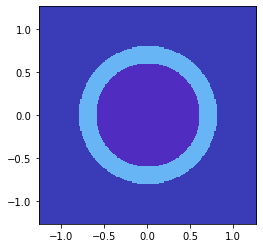

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()


In [7]:
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml")
power = 1e4;
days = 24*3600;
time_steps = [0.1*days, 0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days,365.*days,365.*days,365.*days,730.*days,730.*days]

integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5


 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Cr50 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr50.h5
 Reading Cr52 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr52.h5
 Reading Cr5

 Reading Se80 from /home/sblair/OMC_DATA/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb7

          1200K
          2500K


 Reading Cd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/O

          1200K
          2500K


 Reading Sn125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn125.h5
 Reading Sn126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5


          1200K
          2500K


 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5


          1200K
          2500K


 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf246 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5


          1200K


 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.44528
        2/1    1.45343
        3/1    1.46771
        4/1    1.47502
        5/1    1.47053
        6/1    1.43520
        7/1    1.44983
        8/1    1.48060
        9/1    1.46818
       10/1    1.46656
       11/1    1.46894
       12/1    1.44577
       13/1    1.44907
       14/1    1.43972
       15/1    1.46652
       16/1    1.45169
       17/1    1.45767
       18/1    1.46097
       19/1    1.44872
       20/1    1.44323
       21/1    1.46988
       22/1    1.45530
       23/1    1.46270
       24/1    1.47038
       25/1    1.46049
       26/1    1.46334
       27/1    1.46070
       28/1    1.46906
       29/1    1.45237
       30/1    1.46728
       31/1    1.46262
       32/1    1.47121
       33/1    1.46529
       34/1    1.47018
       35/1    1.46

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.44074
        2/1    1.41997
        3/1    1.46217
        4/1    1.47335
        5/1    1.44585
        6/1    1.46260
        7/1    1.48021
        8/1    1.44929
        9/1    1.43872
       10/1    1.45226
       11/1    1.50207
       12/1    1.44275
       13/1    1.46378
       14/1    1.45456
       15/1    1.45109
       16/1    1.46288
       17/1    1.46630
       18/1    1.47460
       19/1    1.45562
       20/1    1.47886
       21/1    1.44333
       22/1    1.45794
       23/1    1.46546
       24/1    1.46830
       25/1    1.47652
       26/1    1.43312
       27/1    1.45654
       28/1    1.44626
       29/1    1.45618
       30/1    1.44987
       31/1    1.45505
       32/1    1.44790
       33/1    1.44687
       34/1    1.46708
       35/1    1.45

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.45133
        2/1    1.45337
        3/1    1.45254
        4/1    1.46349
        5/1    1.44049
        6/1    1.45471
        7/1    1.47307
        8/1    1.47036
        9/1    1.48509
       10/1    1.44863
       11/1    1.45242
       12/1    1.45737
       13/1    1.43271
       14/1    1.47277
       15/1    1.45425
       16/1    1.44778
       17/1    1.47012
       18/1    1.44447
       19/1    1.45932
       20/1    1.43270
       21/1    1.46529
       22/1    1.47384
       23/1    1.43759
       24/1    1.45342
       25/1    1.44919
       26/1    1.46254
       27/1    1.45355
       28/1    1.46486
       29/1    1.42977
       30/1    1.47541
       31/1    1.46828
       32/1    1.44676
       33/1    1.44374
       34/1    1.44961
       35/1    1.45

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.44254
        2/1    1.39842
        3/1    1.45164
        4/1    1.43681
        5/1    1.42779
        6/1    1.43298
        7/1    1.43363
        8/1    1.44386
        9/1    1.44189
       10/1    1.44834
       11/1    1.43745
       12/1    1.46104
       13/1    1.44814
       14/1    1.45345
       15/1    1.44342
       16/1    1.43446
       17/1    1.45720
       18/1    1.42882
       19/1    1.45239
       20/1    1.44864
       21/1    1.44054
       22/1    1.46020
       23/1    1.43942
       24/1    1.39902
       25/1    1.44551
       26/1    1.44575
       27/1    1.47510
       28/1    1.45556
       29/1    1.44135
       30/1    1.45481
       31/1    1.42592
       32/1    1.44030
       33

      200/1    1.44837    1.44228 +/- 0.00099
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.0905e+03 seconds
   Time in transport only          = 2.0897e+03 seconds
   Time in inactive batches        = 4.1849e+02 seconds
   Time in active batches          = 1.6720e+03 seconds
   Time synchronizing fission bank = 4.6570e-01 seconds
     Sampling source sites         = 4.1916e-01 seconds
     SEND/RECV source sites        = 4.5550e-02 seconds
   Time accumulating tallies       = 2.8036e-02 seconds
   Time writing statepoints        = 1.9268e-02 seconds
 Total time for finalization       = 1.8241e-03 seconds
 Total time elapsed                = 2.0909e+03 seconds
 Calculation Rate (inactive)       = 2389.52 particles/second
 Calculation Rate (active)         = 1794.

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.42104
        2/1    1.41682
        3/1    1.41934
        4/1    1.44153
        5/1    1.41815
        6/1    1.40527
        7/1    1.41577
        8/1    1.42312
        9/1    1.39701
       10/1    1.45373
       11/1    1.42872
       12/1    1.42973
       13/1    1.40629
       14/1    1.43044
       15/1    1.44036
       16/1    1.39923
       17/1    1.42614
       18/1    1.45142
       19/1    1.43941
       20/1    1.44327
       21/1    1.41894
       22/1    1.42950
       23/1    1.43540
       24/1    1.42283
       25/1    1.44363
       26/1    1.40100
       27/1    1.41747
       28/1    1.41357
       29/1    1.43216
       30/1    1.44087
       31/1    1.42420
       32/1    1.41839
       33/1    1.44401
       34/1    1.42081
       35/1    1.43

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.39075
        2/1    1.41542
        3/1    1.41408
        4/1    1.41560
        5/1    1.41516
        6/1    1.42346
        7/1    1.41908
        8/1    1.38906
        9/1    1.45198
       10/1    1.43099
       11/1    1.41200
       12/1    1.41242
       13/1    1.41307
       14/1    1.42042
       15/1    1.42604
       16/1    1.40859
       17/1    1.40844
       18/1    1.40959
       19/1    1.43340
       20/1    1.42468
       21/1    1.41711
       22/1    1.40898
       23/1    1.43524
       24/1    1.42507
       25/1    1.42269
       26/1    1.40736
       27/1    1.42040
       28/1    1.41532
       29/1    1.42971
       30/1    1.40919
       31/1    1.39331
       32/1    1.41921
       33/1    1.41658
       34/1    1.41695
       35/1    1.42

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.38917
        2/1    1.38645
        3/1    1.39171
        4/1    1.40927
        5/1    1.39809
        6/1    1.40400
        7/1    1.39859
        8/1    1.42080
        9/1    1.41236
       10/1    1.39186
       11/1    1.40053
       12/1    1.40597
       13/1    1.39015
       14/1    1.41104
       15/1    1.40155
       16/1    1.39067
       17/1    1.40210
       18/1    1.38514
       19/1    1.40391
       20/1    1.40170
       21/1    1.39279
       22/1    1.34466
       23/1    1.40315
       24/1    1.39485
       25/1    1.37028
       26/1    1.40115
       27/1    1.39415
       28/1    1.41325
       29/1    1.40614
       30/1    1.42525
       31/1    1.40936
       32/1    1.39789
       33/1    1.39887
       34/1    1.39235
       35/1    1.38

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.37149
        2/1    1.39201
        3/1    1.38310
        4/1    1.37180
        5/1    1.36919
        6/1    1.37891
        7/1    1.38332
        8/1    1.38772
        9/1    1.39270
       10/1    1.37127
       11/1    1.39651
       12/1    1.37941
       13/1    1.38382
       14/1    1.38903
       15/1    1.38892
       16/1    1.39512
       17/1    1.37870
       18/1    1.38086
       19/1    1.37851
       20/1    1.39223
       21/1    1.39199
       22/1    1.39582
       23/1    1.38590
       24/1    1.38902
       25/1    1.37476
       26/1    1.40734
       27/1    1.38139
       28/1    1.36192
       29/1    1.37728
       30/1    1.40167
       31/1    1.38410
       32/1    1.39826
       33/1    1.38893
       34/1    1.38496
       35/1    1.37

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.33691
        2/1    1.31913
        3/1    1.33648
        4/1    1.34348
        5/1    1.35392
        6/1    1.34334
        7/1    1.34172
        8/1    1.34597
        9/1    1.36705
       10/1    1.34093
       11/1    1.35443
       12/1    1.33264
       13/1    1.36679
       14/1    1.32327
       15/1    1.34830
       16/1    1.33379
       17/1    1.32701
       18/1    1.34872
       19/1    1.34395
       20/1    1.33936
       21/1    1.34878
       22/1    1.35985
       23/1    1.34679
       24/1    1.35808
       25/1    1.35506
       26/1    1.34232
       27/1    1.35613
       28/1    1.36030
       29/1    1.34224
       30/1    1.33733
       31/1    1.35205
       32/1    1.32740
       33/1    1.34223
       34/1    1.35096
       35/1    1.34

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.19403
        2/1    1.20113
        3/1    1.21534
        4/1    1.21099
        5/1    1.20819
        6/1    1.23291
        7/1    1.18226
        8/1    1.20194
        9/1    1.22017
       10/1    1.18879
       11/1    1.20542
       12/1    1.19958
       13/1    1.20356
       14/1    1.21848
       15/1    1.21861
       16/1    1.21951
       17/1    1.19308
       18/1    1.22286
       19/1    1.19557
       20/1    1.21936
       21/1    1.23398
       22/1    1.21597
       23/1    1.21210
       24/1    1.20863
       25/1    1.22098
       26/1    1.21331
       27/1    1.22344
       28/1    1.21803
       29/1    1.22869
       30/1    1.22499
       31/1    1.19761
       32/1    1.23051
       33/1    1.21335
       34/1    1.19131
       35/1    1.22

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.09014
        2/1    1.08931
        3/1    1.13731
        4/1    1.13244
        5/1    1.12464
        6/1    1.11332
        7/1    1.11142
        8/1    1.12308
        9/1    1.10094
       10/1    1.11297
       11/1    1.11792
       12/1    1.14751
       13/1    1.13465
       14/1    1.13134
       15/1    1.12206
       16/1    1.11768
       17/1    1.11118
       18/1    1.11616
       19/1    1.12832
       20/1    1.12418
       21/1    1.10341
       22/1    1.12094
       23/1    1.13777
       24/1    1.13881
       25/1    1.09270
       26/1    1.12758
       27/1    1.09914
       28/1    1.15553
       29/1    1.12129
       30/1    1.13418
       31/1    1.12657
       32/1    1.11991
       33/1    1.12773
       34/1    1.12137
       35/1    1.11

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.00384
        2/1    1.04015
        3/1    1.02284
        4/1    1.03081
        5/1    1.02013
        6/1    1.04443
        7/1    1.04254
        8/1    1.03673
        9/1    1.06048
       10/1    1.04531
       11/1    1.01747
       12/1    1.03750
       13/1    1.03275
       14/1    1.05367
       15/1    1.03614
       16/1    1.04397
       17/1    1.02334
       18/1    1.02566
       19/1    1.04967
       20/1    1.05125
       21/1    1.04078
       22/1    1.04269
       23/1    1.03432
       24/1    1.03252
       25/1    1.04216
       26/1    1.03088
       27/1    1.05038
       28/1    1.03188
       29/1    1.04506
       30/1    1.03289
       31/1    1.03426
       32/1    1.04238
       33/1    1.02026
       34/1    1.03782
       35/1    1.03

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.87453
        2/1    0.87397
        3/1    0.88907
        4/1    0.89952
        5/1    0.90388
        6/1    0.89711
        7/1    0.89647
        8/1    0.90726
        9/1    0.89970
       10/1    0.88671
       11/1    0.89354
       12/1    0.91264
       13/1    0.91082
       14/1    0.91702
       15/1    0.89239
       16/1    0.90295
       17/1    0.90193
       18/1    0.89822
       19/1    0.90838
       20/1    0.92427
       21/1    0.90620
       22/1    0.90852
       23/1    0.91343
       24/1    0.91591
       25/1    0.90700
       26/1    0.90114
       27/1    0.90548
       28/1    0.90176
       29/1    0.89973
       30/1    0.88223
       31/1    0.90938
       32/1    0.88709
       33/1    0.90004
       34/1    0.90085
       35/1    0.89

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.75736
        2/1    0.76635
        3/1    0.76558
        4/1    0.78442
        5/1    0.77902
        6/1    0.78769
        7/1    0.79109
        8/1    0.77617
        9/1    0.77292
       10/1    0.78671
       11/1    0.78483
       12/1    0.76157
       13/1    0.79694
       14/1    0.77216
       15/1    0.79740
       16/1    0.76833
       17/1    0.76184
       18/1    0.77415
       19/1    0.76681
       20/1    0.77858
       21/1    0.79711
       22/1    0.76921
       23/1    0.78520
       24/1    0.79132
       25/1    0.79003
       26/1    0.78154
       27/1    0.76864
       28/1    0.78051
       29/1    0.78444
       30/1    0.78002
       31/1    0.77901
       32/1    0.78164
       33/1    0.78681
       34/1    0.76861
       35/1    0.78

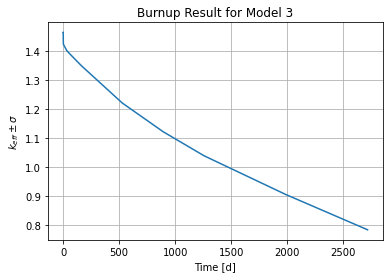

In [8]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

time,k = results.get_eigenvalue()
time /= (24*60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Model 3')
plt.xlabel('Time [d]')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()



Text(0, 0.5, 'Number of atoms Cs137')

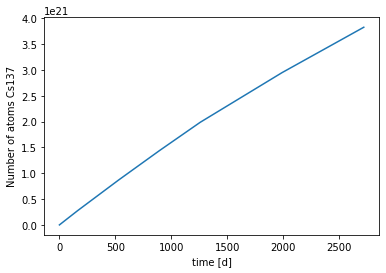

In [9]:
time, cs137 = results.get_atoms("1","Cs137")# I should verify that fuel is material "1"
time /= (24*60*60)
plt.plot(time,cs137,label="Cs137")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Cs137")

Text(0, 0.5, 'Number of atoms Pu239')

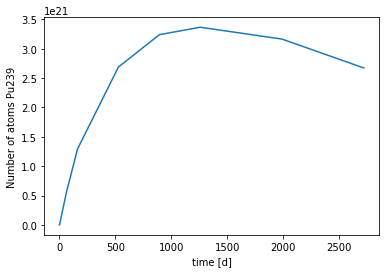

In [10]:
time, Pu239 = results.get_atoms("1","Pu239")

time /= (24*60*60)
plt.plot(time,Pu239,label="Pu239")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Pu239")

Text(0, 0.5, 'Number of atoms')

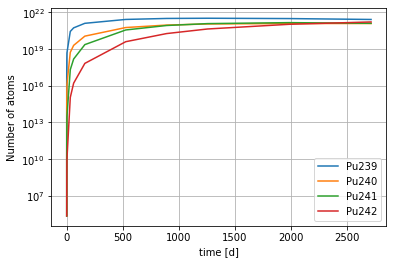

In [11]:
time, Pu240 = results.get_atoms("1","Pu240")
time, Pu241 = results.get_atoms("1","Pu241")
time, Pu242 = results.get_atoms("1","Pu242")
time /= (24*60*60)

plt.semilogy(time,Pu239,label="Pu239")
plt.semilogy(time,Pu240,label="Pu240")
plt.semilogy(time,Pu241,label="Pu241")
plt.semilogy(time,Pu242,label="Pu242")
plt.legend()
plt.grid()
plt.xlabel("time [d]")
plt.ylabel("Number of atoms")

Text(0, 0.5, 'Fraction Pu239')

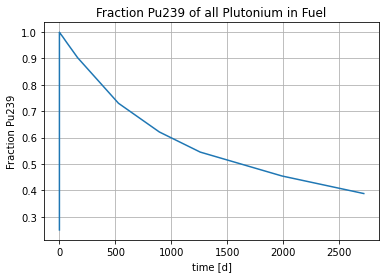

In [12]:
total_pu = Pu239 + Pu240 + Pu241 + Pu242
Pu239_frac = Pu239/total_pu

plt.plot(time,Pu239_frac,label="Fraction Pu239")
plt.grid()
plt.title("Fraction Pu239 of all Plutonium in Fuel")
plt.xlabel("time [d]")
plt.ylabel("Fraction Pu239")